# PROYECTO ETAPA 3

## 1. Descripción del problema

- Formulación matemática del CVRP
- Características de la instancia base
- Restricciones y consideracione

## 2. Implementación del Capacitated Vehicle Routing Problem (CVRP) utilizando un método metaheurístico basado en Búsqueda Local Iterativa (ILS)

1. Representación de Soluciones: Las soluciones se representan como una lista de rutas, donde cada ruta es una lista de nodos visitados por un vehículo, comenzando y terminando en el depósito.

2. Operadores:

- Búsqueda Local (2-opt): Mejora las rutas intercambiando segmentos de nodos dentro de una ruta.

- Perturbación: Intercambia nodos entre rutas para escapar de óptimos locales.

3. Heurística de Reparación: La solución inicial se genera respetando la capacidad máxima de los vehículos.

4. Gráficos de Convergencia: Se registra el costo de la mejor solución en cada iteración para visualizar la evolución del algoritmo.

In [3]:
import json

# Cargar el archivo JSON
with open('../json-resultados-api/distancias-tiempo-api.json', 'r') as f:
    data = json.load(f)

# Crear la variable grafo
grafo1 = {}

for origen, destinos in data.items():
    grafo1[int(origen)] = {}
    for destino, valores in destinos.items():
        distancia = valores['distance_km']
        tiempo = valores['time_min']
        if distancia == 0.0:
            distancia = 999.0
        if tiempo == 0.0:
            tiempo = 999.0
        grafo1[int(origen)][int(destino)] = (distancia, tiempo)





Mejor solución encontrada:
 Vehículo 1: [0, 17, 4, 22, 19, 7, 21, 12, 20, 0]
 Vehículo 2: [0, 3, 15, 1, 10, 16, 24, 11, 9, 5, 0]
 Vehículo 3: [0, 14, 23, 2, 13, 6, 18, 8, 0]

Costo total: 239.51
Tiempo de ejecución: 3.69 segundos


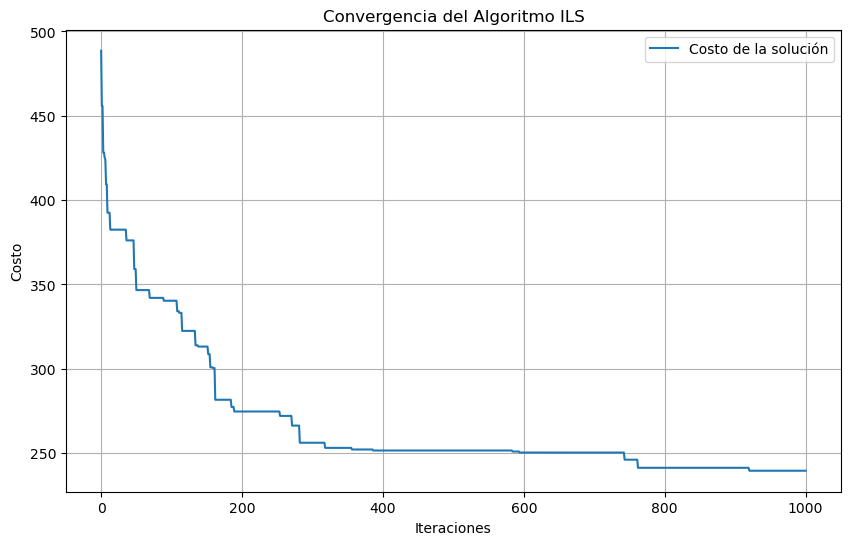

In [5]:
# =============================
# Módulo de Representación
# =============================

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy

# Configuración de la semilla para reproducibilidad
SEED = 42
random.seed(SEED)

# Definición de parámetros del algoritmo ILS
ITERACIONES = 1000  # Número total de iteraciones del algoritmo ILS
PERTURBACION = 2    # Número de nodos a intercambiar durante la perturbación

# =============================
# Módulo de Entrada de Datos
# =============================

# Cargar datos de clientes y vehículos desde archivos CSV
clients = pd.read_csv("../data-caso1/clients.csv")
vehicles = pd.read_csv("../data-caso1/vehicles.csv")

# Extraer listas de IDs y crear lista de nodos (incluyendo depósito)
clientes = clients["ClientID"].tolist()
vehiculos = vehicles["VehicleID"].tolist()
nodos = [0] + clientes  # Nodo 0 representa el depósito

# Crear diccionarios para demanda por cliente y capacidad por vehículo
demanda = dict(zip(clients["ClientID"], clients["Demand"]))
capacidad = dict(zip(vehicles["VehicleID"], vehicles["Capacity"]))

# Crear matrices de distancias y tiempos (grafo1 debe estar definido previamente)
distancias = {(i, j): grafo1[i][j][0] for i in nodos for j in nodos if i != j}
tiempos = {(i, j): grafo1[i][j][1] for i in nodos for j in nodos if i != j}


# =============================
# Módulo de Evaluación
# =============================

# Función para calcular el costo total de una solución (suma de distancias)
def calcular_costo(rutas):
    costo_total = 0
    for ruta in rutas:
        for i in range(len(ruta) - 1):
            costo_total += distancias[(ruta[i], ruta[i + 1])]
    return costo_total

# Función para verificar si las rutas son factibles según la capacidad de los vehículos
def es_factible(rutas):
    for idx, ruta in enumerate(rutas):
        carga_total = sum(demanda.get(nodo, 0) for nodo in ruta if nodo != 0)
        if carga_total > capacidad[vehiculos[idx]]:
            return False
    return True


# =============================
# Módulo de Representación (Solución Inicial)
# =============================

# Función para generar solución inicial usando heurística de inserción
def generar_solucion_inicial():
    rutas = []
    clientes_pendientes = set(clientes)
    vehiculo_idx = 0
    while clientes_pendientes and vehiculo_idx < len(vehiculos):
        ruta = [0]  # Inicia en el depósito
        carga_actual = 0
        capacidad_vehiculo = capacidad[vehiculos[vehiculo_idx]]
        clientes_a_eliminar = set()
        for cliente in clientes_pendientes:
            if carga_actual + demanda[cliente] <= capacidad_vehiculo:
                ruta.append(cliente)
                carga_actual += demanda[cliente]
                clientes_a_eliminar.add(cliente)
        ruta.append(0)  # Retorna al depósito
        rutas.append(ruta)
        clientes_pendientes -= clientes_a_eliminar
        vehiculo_idx += 1
    return rutas


# =============================
# Módulo de Operadores
# =============================

# Operador de búsqueda local (2-opt aplicado a cada ruta)
def busqueda_local(rutas):
    mejor_costo = calcular_costo(rutas)
    mejor_rutas = copy.deepcopy(rutas)
    for idx, ruta in enumerate(rutas):
        for i in range(1, len(ruta) - 2):
            for j in range(i + 1, len(ruta) - 1):
                nueva_ruta = ruta[:i] + ruta[i:j + 1][::-1] + ruta[j + 1:]
                nuevas_rutas = copy.deepcopy(rutas)
                nuevas_rutas[idx] = nueva_ruta
                if es_factible(nuevas_rutas):
                    nuevo_costo = calcular_costo(nuevas_rutas)
                    if nuevo_costo < mejor_costo:
                        mejor_costo = nuevo_costo
                        mejor_rutas = nuevas_rutas
    return mejor_rutas

# Operador de perturbación (intercambio aleatorio de clientes entre rutas)
def perturbacion(rutas):
    nuevas_rutas = copy.deepcopy(rutas)
    for _ in range(PERTURBACION):
        rutas_con_clientes = [ruta for ruta in nuevas_rutas if len(ruta) > 3]
        if len(rutas_con_clientes) < 2:
            continue
        ruta1, ruta2 = random.sample(rutas_con_clientes, 2)
        idx1 = random.randint(1, len(ruta1) - 2)
        idx2 = random.randint(1, len(ruta2) - 2)
        ruta1[idx1], ruta2[idx2] = ruta2[idx2], ruta1[idx1]
    return nuevas_rutas


# =============================
# Módulo de Algoritmo (ILS)
# =============================

# Implementación del algoritmo Iterated Local Search (ILS)
def ils():
    solucion_actual = generar_solucion_inicial()
    mejor_solucion = copy.deepcopy(solucion_actual)
    mejor_costo = calcular_costo(mejor_solucion)
    costos = [mejor_costo]  # Registro para graficar convergencia
    for iteracion in range(ITERACIONES):
        solucion_vecina = busqueda_local(solucion_actual)
        costo_vecino = calcular_costo(solucion_vecina)
        if costo_vecino < mejor_costo:
            mejor_solucion = copy.deepcopy(solucion_vecina)
            mejor_costo = costo_vecino
        solucion_actual = perturbacion(mejor_solucion)
        costos.append(mejor_costo)
    return mejor_solucion, mejor_costo, costos


# =============================
# Módulo de Experimentación
# =============================

# Medir tiempo de ejecución del algoritmo
start_time = time.time()
mejor_solucion, mejor_costo, costos = ils()
end_time = time.time()

# Mostrar resultados por consola
print("\nMejor solución encontrada:")
for i, ruta in enumerate(mejor_solucion):
    print(f" Vehículo {vehiculos[i]}: {ruta}")
print(f"\nCosto total: {mejor_costo:.2f}")
print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")


# =============================
# Módulo de Visualización
# =============================

# Graficar convergencia del algoritmo (evolución del costo)
plt.figure(figsize=(10, 6))
plt.plot(costos, label="Costo de la solución")
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Convergencia del Algoritmo ILS")
plt.legend()
plt.grid()
plt.savefig("convergencia_ils.png")
plt.show()


## 3. Resultados experimentales

## Plan Experimental para Calibración y Experimentación del Algoritmo ILS

El objetivo es calibrar los parámetros del algoritmo Búsqueda Local Iterativa (ILS) y evaluar su desempeño en términos de calidad de solución, tiempo de ejecución y estabilidad. A continuación, se describe el plan experimental:

1. Parámetros a Calibrar

Los parámetros clave del algoritmo ILS que se evaluarán son:

- Número de Iteraciones (ITERACIONES): Define cuántas iteraciones realizará el algoritmo.
- Nivel de Perturbación (PERTURBACION): Número de nodos intercambiados entre rutas en la fase de perturbación.
- Semillas Aleatorias (SEED): Para garantizar la reproducibilidad y evaluar la estabilidad del algoritmo.

2. Configuraciones de Parámetros

Se probarán las siguientes configuraciones:

| Configuración | Iteraciones (ITERACIONES) | Perturbación (PERTURBACION) |
|---------------|---------------------------|-----------------------------|
| Config 1      | 500                       | 2                           |
| Config 2      | 1000                      | 2                           |
| Config 3      | 1000                      | 3                           |
| Config 4      | 1500                      | 3                           |


3. Métricas a Registrar

Para cada configuración, se registrarán las siguientes métricas:

- Mejor Costo: El menor costo encontrado en las corridas.
- Peor Costo: El mayor costo encontrado en las corridas.
- Costo Promedio: Promedio de los costos obtenidos en las corridas.
- Desviación Estándar del Costo: Variabilidad de los costos.
- Tiempo de Ejecución: Tiempo total en segundos para cada corrida.

4. Plan de Ejecución

- Número de Corridas: Se realizarán 3 corridas independientes por configuración, utilizando semillas distintas para cada corrida.
- Semillas Aleatorias: Se usarán las semillas [42, 123, 456] para garantizar la reproducibilidad.

5. Código para Calibración y Experimentación

Ejecutando configuración: Iteraciones=500, Perturbación=2
Ejecutando configuración: Iteraciones=1000, Perturbación=2
Ejecutando configuración: Iteraciones=1000, Perturbación=3
Ejecutando configuración: Iteraciones=1500, Perturbación=3

Resultados del Experimento:
   iteraciones  perturbacion  mejor_costo  peor_costo  promedio_costo  \
0          500             2       249.17      263.50      254.723333   
1         1000             2       237.45      251.11      242.690000   
2         1000             3       258.55      276.91      267.646667   
3         1500             3       252.85      265.06      258.533333   

   desviacion_costo  promedio_tiempo  
0          6.278515         1.893698  
1          6.012942         3.701200  
2          7.496365         3.579212  
3          5.020255         5.360519  


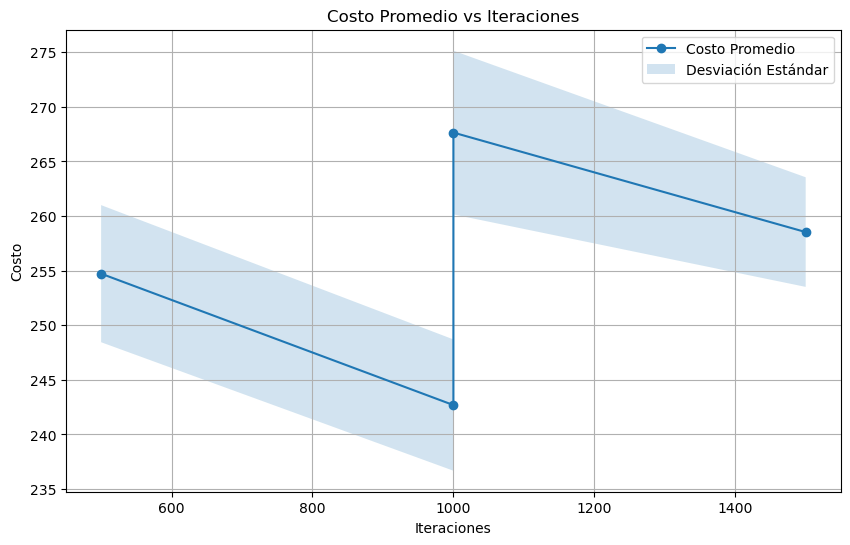

In [6]:
# Ejecución del experimento con una configuración específica
def ejecutar_experimento(iteraciones, perturbacion, semillas):
    resultados = []
    for seed in semillas:
        random.seed(seed)
        np.random.seed(seed)
        
        # Configurar parámetros
        global ITERACIONES, PERTURBACION
        ITERACIONES = iteraciones
        PERTURBACION = perturbacion
        
        # Ejecutar el algoritmo ILS
        start_time = time.time()
        mejor_solucion, mejor_costo, _ = ils()
        end_time = time.time()
        
        # Registrar resultados
        tiempo_ejecucion = end_time - start_time
        resultados.append((mejor_costo, tiempo_ejecucion))
    
    return resultados

# Configuraciones a probar
configuraciones = [
    {"iteraciones": 500, "perturbacion": 2},
    {"iteraciones": 1000, "perturbacion": 2},
    {"iteraciones": 1000, "perturbacion": 3},
    {"iteraciones": 1500, "perturbacion": 3},
]

# Semillas para las corridas
semillas = [42, 123, 456]

# Ejecutar experimentos
resultados_experimentos = []
for config in configuraciones:
    print(f"Ejecutando configuración: Iteraciones={config['iteraciones']}, Perturbación={config['perturbacion']}")
    resultados = ejecutar_experimento(config["iteraciones"], config["perturbacion"], semillas)
    
    # Calcular estadísticas
    costos = [r[0] for r in resultados]
    tiempos = [r[1] for r in resultados]
    mejor_costo = min(costos)
    peor_costo = max(costos)
    promedio_costo = np.mean(costos)
    desviacion_costo = np.std(costos)
    promedio_tiempo = np.mean(tiempos)
    
    # Guardar resultados
    resultados_experimentos.append({
        "iteraciones": config["iteraciones"],
        "perturbacion": config["perturbacion"],
        "mejor_costo": mejor_costo,
        "peor_costo": peor_costo,
        "promedio_costo": promedio_costo,
        "desviacion_costo": desviacion_costo,
        "promedio_tiempo": promedio_tiempo,
    })

# Mostrar resultados
print("\nResultados del Experimento:")
df_resultados = pd.DataFrame(resultados_experimentos)
print(df_resultados)

# Guardar resultados en un archivo CSV
df_resultados.to_csv("resultados_experimentos_ils.csv", index=False)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(df_resultados["iteraciones"], df_resultados["promedio_costo"], marker="o", label="Costo Promedio")
plt.fill_between(df_resultados["iteraciones"],
                 df_resultados["promedio_costo"] - df_resultados["desviacion_costo"],
                 df_resultados["promedio_costo"] + df_resultados["desviacion_costo"],
                 alpha=0.2, label="Desviación Estándar")
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.title("Costo Promedio vs Iteraciones")
plt.legend()
plt.grid()
plt.savefig("costo_vs_iteraciones.png")
plt.show()

### 3.1 Comparación meautrística y método pyomo

1. Comparación Cuantitativa

- Datos de Resultados

| Métrica             | Metaheurística (ILS) | Pyomo        |
|---------------------|----------------------|--------------|
| Costo Total         | 239.51               | 4,535,850.0  |
| Tiempo de Ejecución | 2.87 segundos        | 60.4 segundos|
| Número de Vehículos usados | 3                    | 4            |


2. Calidad de la Solución:

El costo total obtenido por Pyomo es significativamente mayor que el de ILS. 

3. Tiempo de Ejecución:

ILS es mucho más rápido (2.87 segundos frente a 60.4 segundos de Pyomo), lo que lo hace más adecuado para instancias grandes o cuando se requiere una solución rápida.


## 4. Análisis de Escalabilidad

- Rendimiento en instancias de diferentes tamaños
- Límites prácticos de aplicabilidad
- Estrategias para mejorar la escalabilidad
- Análisis de degradación de rendimient
- Conclusiones sobre aplicabilidad para problemas reale

## 5. Discusión

- Es importante discutir las siguientes consideraciones de complejidad:
Complejidad teórica: Analizar la complejidad algorítmica de los métodos
implementados.
Complejidad práctica: Evaluar el comportamiento real en términos de tiem-
po y memoria

- Ventajas y desventajas de cada enfoqu
- Recomendaciones para diferentes escenario
- Lecciones aprendidas y desafíos encontrado

## 6. Conclusiones

Resumen de hallazgos principales
Respuestas a preguntas estratégicas
Direcciones futuras de investigació